# Summary

Extending the analysis by adding a new model. This approach is
roughly equivalent to choosing a number of stars by random. I'm
not sure how much we can debug this model, etc., before the paper
is due. It seems like the authors of the paper we're replicating
chose to use a continuous dependent variable and transformations
to move away from what we're seeing here... even though their
approach has a very academic outcome. 


I'm pretty much trying to replicate homework 8a and 8b using
our Yelp dataset and the features from the paper.

Let me know what you think. Thanks, Tyler.


# Dependencies

In [26]:
import itertools
from itertools import cycle

import graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score,
                             classification_report, roc_curve,
                             roc_auc_score, confusion_matrix, 
                             precision_recall_curve, average_precision_score)

%matplotlib inline

# Helper Functions

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Reference:
      http://scikit-learn.org/stable/auto_examples/
         model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load Data

In [5]:
X_train = pd.read_parquet("X_train_spec.parquet", engine="pyarrow")
y_train = pd.read_parquet("y_train_spec.parquet", engine="pyarrow")

In [6]:
X_test = pd.read_parquet("X_test_spec.parquet", engine="pyarrow")
y_test = pd.read_parquet("y_test_spec.parquet", engine="pyarrow")

# Features

In [7]:
X_train = X_train[['uRate', 'bRate', 'rCount', 'tlen', 'tpol', 'tsub', 'uAvg', 'bAvg']]
X_test = X_test[['uRate', 'bRate', 'rCount', 'tlen', 'tpol', 'tsub', 'uAvg', 'bAvg']]

# Generic Analysis

In [11]:
clf = tree.DecisionTreeClassifier(class_weight="balanced")

In [12]:
clf = clf.fit(X_train, y_train)

In [13]:
pred = clf.predict(X_test)

In [14]:
clf.score(X_test, y_test)

0.26378406416665506

In [20]:
precision = precision_score(y_test, pred, average="macro")
print('Precision value: {0:0.2f}'.format(precision))

recall = recall_score(y_test, pred, average="macro")
print('Recall value: {0:0.2f}'.format(recall))

Precision value: 0.20
Recall value: 0.20


In [24]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          1       0.12      0.12      0.12    205634
          2       0.09      0.10      0.09    148108
          3       0.13      0.14      0.14    225816
          4       0.26      0.26      0.26    442020
          5       0.41      0.38      0.40    701934

avg / total       0.27      0.26      0.27   1723512



Confusion matrix, without normalization
[[ 25611  19476  28542  52848  79157]
 [ 18210  14201  20893  37736  57068]
 [ 27938  21575  31566  57469  87268]
 [ 55194  42136  61654 113633 169403]
 [ 87153  66671  98233 180253 269624]]


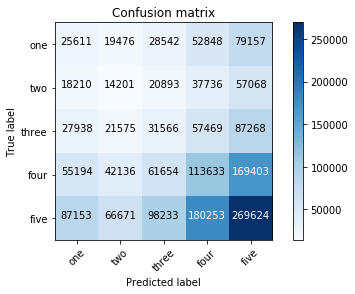

In [27]:
class_names = ["one", "two", "three", "four", "five"]
cnf_matrix = confusion_matrix(y_test, pred)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

# Implementing under-sampling due to imbalanced classes

Reference [imblearn](http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html), a scikit-learn contribution module.

In [ ]:
pipe = Pipeline([
    ('rus', RandomUnderSampler(random_state=0)), 
    ('classifier', tree.DecisionTreeClassifier())
])

In [ ]:
#pipe.fit(X_train, y_train)

In [ ]:
#pipe.predict(X_test)